### Step 1: Load the dataset

In [1]:
from sklearn.datasets import fetch_20newsgroups
newsgroups_train = fetch_20newsgroups(subset='train', shuffle = True)
newsgroups_test = fetch_20newsgroups(subset='test', shuffle = True)

In [2]:
print(list(newsgroups_train.target_names))

['alt.atheism', 'comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware', 'comp.windows.x', 'misc.forsale', 'rec.autos', 'rec.motorcycles', 'rec.sport.baseball', 'rec.sport.hockey', 'sci.crypt', 'sci.electronics', 'sci.med', 'sci.space', 'soc.religion.christian', 'talk.politics.guns', 'talk.politics.mideast', 'talk.politics.misc', 'talk.religion.misc']


### Step 2: Data Preprocessing¶


In [3]:
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
import numpy as np
np.random.seed(400)

import nltk

import pandas as pd
stemmer = SnowballStemmer("english")

In [4]:
def lemmatize_stemming(text):
    return stemmer.stem(WordNetLemmatizer().lemmatize(text, pos='v'))

# Tokenize and lemmatize
def preprocess(text):
    result=[]
    for token in gensim.utils.simple_preprocess(text) :
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3:
            result.append(lemmatize_stemming(token))
            
    return result

In [5]:
processed_docs = []

for doc in newsgroups_train.data:
    processed_docs.append(preprocess(doc))

### Step 3: Bag of words

In [6]:
# Create the dictionnary
from nautilus_nlp.models.topic_modeling import create_dictionary

In [7]:
dictionary = create_dictionary(processed_docs)

In [8]:
# Filter out tokens that appear in too few or too many documents
from nautilus_nlp.models.topic_modeling import filter_extremes

In [9]:
filter_extremes(dictionary)

In [10]:
# Create the bow 
from nautilus_nlp.models.topic_modeling import create_bow_corpus

In [11]:
bow_corpus = create_bow_corpus(processed_docs, dictionary)

In [12]:
print(bow_corpus[3])

[(13, 1), (26, 1), (55, 1), (88, 1), (99, 1), (152, 1), (153, 2), (154, 1), (155, 1), (156, 1), (157, 2), (158, 1), (159, 2), (160, 4), (161, 1), (162, 2), (163, 1), (164, 2), (165, 1), (166, 1), (167, 1), (168, 1), (169, 1), (170, 1), (171, 1), (172, 1), (173, 1), (174, 1), (175, 1), (176, 1), (177, 1), (178, 2), (179, 1), (180, 1), (181, 1), (182, 1)]


### Step 4: Find optimal number of topics

In [13]:
# Compute coherence values for various number of topics in order to pick the optimal one
from nautilus_nlp.models.topic_modeling import compute_coherence_values

In [14]:
# Take a long time to run
model_list, coherence_values = compute_coherence_values(dictionary=dictionary, bow_corpus=bow_corpus, texts=processed_docs, start=2, limit=25, step=4)


In [17]:
coherence_values

[0.37900998646286865,
 0.42680154447577845,
 0.47716566398237525,
 0.5261650723885645,
 0.49607461078243215,
 0.4978727171365794]

In [2]:
from nautilus_nlp.models.topic_modeling import plot_optimal_topic_number

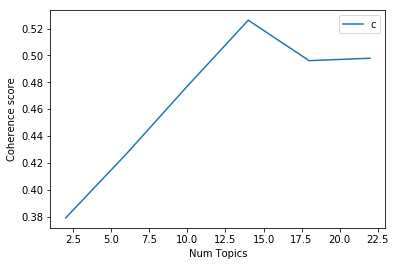

In [3]:
plot_optimal_topic_number(coherence_values, start=2, limit=25, step=4)

In [4]:
# Print the coherences scores for the number we tested
from nautilus_nlp.models.topic_modeling import print_coherence_scores

In [5]:
print_coherence_scores(coherence_values)

Num Topics = 2  has Coherence Value of 0.379
Num Topics = 6  has Coherence Value of 0.4268
Num Topics = 10  has Coherence Value of 0.4772
Num Topics = 14  has Coherence Value of 0.5262
Num Topics = 18  has Coherence Value of 0.4961
Num Topics = 22  has Coherence Value of 0.4979


### Step 5: Running LDA using Bag of Words with Gensim or Mallet

#### Gensim

In [13]:
# Train the LDA model with gensim
from nautilus_nlp.models.topic_modeling import train_lda_model

In [14]:
# By default the model used will be gensim implementation of LDA
model = train_lda_model(bow_corpus, dictionary, 10)

In [15]:
model

In [53]:
# Save model: The model will be saved on your current emplacement.
from nautilus_nlp.models.topic_modeling import save_model

In [54]:
save_model(model, 'ldamodel_nautilus')

In [24]:
# Load model

In [55]:
model_loaded = load_model('/Users/williamjaubert/nautilus_nlp/notebooks', 'ldamodel_nautilus')
model_loaded

#### Mallet 

In [22]:
# You can train Mallet model by precising 'mallet' in the model parameter and give the path where the mallet-2.0.8 file that has been downloaded 
model_mallet = train_lda_model(bow_corpus, dictionary, 10, model='mallet', mallet_path='/Users/williamjaubert/nautilus_nlp')

In [23]:
model_mallet

In [47]:
save_model(model_mallet, 'ldamodel_mallet_nautilus')

In [52]:
model_mallet_loaded = load_model('/Users/williamjaubert/nautilus_nlp/notebooks', 'ldamodel_mallet_nautilus', model='mallet')
model_mallet_loaded

### Step 6: Visualize the top keywords per topic with Pyldavis interactive chart

In [56]:
# Display the top keywords per topic in a interactive chart
from nautilus_nlp.models.topic_modeling import visualize_topics

In [30]:
# Gensim
p = visualize_topics(model, bow_corpus, dictionary, model_type='gensim')
p

/Users/williamjaubert/anaconda2/envs/nautilus/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


In [31]:
# Mallet
p = visualize_topics(model_mallet, bow_corpus, dictionary, model_type='mallet')
p

/Users/williamjaubert/anaconda2/envs/nautilus/lib/python3.7/site-packages/pyLDAvis/_prepare.py:223: RuntimeWarning: divide by zero encountered in log
  kernel = (topic_given_term * np.log((topic_given_term.T / topic_proportion).T))
/Users/williamjaubert/anaconda2/envs/nautilus/lib/python3.7/site-packages/pyLDAvis/_prepare.py:240: RuntimeWarning: divide by zero encountered in log
  log_lift = np.log(topic_term_dists / term_proportion)
/Users/williamjaubert/anaconda2/envs/nautilus/lib/python3.7/site-packages/pyLDAvis/_prepare.py:241: RuntimeWarning: divide by zero encountered in log
  log_ttd = np.log(topic_term_dists)
/Users/williamjaubert/anaconda2/envs/nautilus/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.con

In [23]:
# Save the pyldavis as HTML
from nautilus_nlp.models.topic_modeling import save_pyldavis

In [24]:
save_pyldavis(p, '/Users/williamjaubert/Documents/Allianz_William/', 'pyldavis_test_func')

In [27]:
# Load the pyldavis HTML
from nautilus_nlp.models.topic_modeling import show_pyldavis

In [26]:
show_pyldavis('/Users/williamjaubert/Documents/Allianz_William/', 'pyldavis_test_func')

### Step 7: Testing model on unseen document

In [74]:
unseen_document = newsgroups_test.data[100]
print(unseen_document)

Subject: help
From: C..Doelle@p26.f3333.n106.z1.fidonet.org (C. Doelle)
Lines: 13

Hello All!

    It is my understanding that all True-Type fonts in Windows are loaded in
prior to starting Windows - this makes getting into Windows quite slow if you
have hundreds of them as I do.  First off, am I correct in this thinking -
secondly, if that is the case - can you get Windows to ignore them on boot and
maybe make something like a PIF file to load them only when you enter the
applications that need fonts?  Any ideas?


Chris

 * Origin: chris.doelle.@f3333.n106.z1.fidonet.org (1:106/3333.26)



In [75]:
# Data preprocessing step for the unseen document
bow_new = dictionary.doc2bow(preprocess(unseen_document))

In [48]:
from nautilus_nlp.models.topic_modeling import fit_data

In [31]:
fit_data(model, bow_new)

[(0, 0.0027796067),
 (1, 0.002779247),
 (2, 0.0027795879),
 (3, 0.0027795406),
 (4, 0.0027792477),
 (5, 0.002779096),
 (6, 0.0027791534),
 (7, 0.20895894),
 (8, 0.76880664),
 (9, 0.0027789928)]

In [1]:
# Show the dominant topics of the new document and their keywords 
from nautilus_nlp.models.topic_modeling import show_dominant_topic

In [147]:
show_dominant_topic(model, bow_new, 3)

Score: 0.7688832879066467	 Topic: ['window', 'drive', 'problem', 'card', 'work']
Score: 0.2088821828365326	 Topic: ['file', 'program', 'mail', 'imag', 'inform']
Score: 0.0027796069625765085	 Topic: ['christian', 'peopl', 'believ', 'jesus', 'say']
